In [17]:
import tensorflow as tf
import numpy as np
import os
import pandas as pd
from matplotlib.ticker import FuncFormatter
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
print(tf.__version__)
print(tf.keras.__version__)

1.15.0
2.2.4-tf


In [3]:
!nvcc --version
print("cudnn version: 7.6.0")

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:04_Central_Daylight_Time_2018
Cuda compilation tools, release 10.0, V10.0.130
cudnn version: 7.6.0


In [4]:
XTrain_variation = pd.read_csv('./xtrain/X_Train_variation.csv')
XTrain_wounded = pd.read_csv('./xtrain/X_Train_wounded.csv')

In [5]:
scaler1 = StandardScaler()
scaler2 = StandardScaler()
XTrain_variation_normal= scaler2.fit_transform(XTrain_variation)
XTrain_wounded_normal = scaler1.fit_transform(XTrain_wounded)

In [6]:
ytrain_variation = np.array([1] * 6681 + [0] * 5410)
ytrain_wounded = np.array([1] * 35 + [0] * 65)

In [7]:
print(len(XTrain_variation))
print(len(XTrain_wounded))

12091
100


In [8]:
XTrain_variation

,start_m,max_min,maxi,mini,final_initial,final,initial,variance,IQR
0,0.0,0.029822,0.321412,0.291590,-0.027046,0.291604,0.318650,3.187848e-05,0.005971
1,500.0,0.014566,0.305356,0.290790,-0.014566,0.290790,0.305356,1.224779e-05,0.005113
2,1000.0,0.011008,0.301112,0.290104,-0.010934,0.290178,0.301112,8.604474e-06,0.005218
3,1500.0,0.008783,0.298201,0.289418,-0.008710,0.289490,0.298201,7.159026e-06,0.004078
4,2000.0,0.009184,0.297613,0.288429,-0.008624,0.288989,0.297613,6.769553e-06,0.004665
...,...,...,...,...,...,...,...,...,...
12086,493500.0,0.000416,0.170957,0.170541,-0.000314,0.170541,0.170854,7.164188e-09,0.000120
12087,494000.0,0.000480,0.170957,0.170478,-0.000106,0.170613,0.170720,1.113787e-08,0.000131
12088,494500.0,0.000489,0.170924,0.170434,-0.000432,0.170447,0.170879,1.410392e-08,0.000171
12089,495000.0,0.000554,0.170924,0.170370,-0.000401,0.170393,0.170794,2.186037e-08,0.000221


In [9]:
XTrain_wounded

,max_min,final_initial,variance,IQR
0,0.173552,0.159892,2.172738e-03,0.039403
1,0.116821,0.071959,6.369545e-04,0.036211
2,0.191092,0.179022,2.968636e-03,0.053951
3,0.187847,0.170960,2.357909e-03,0.039419
4,0.148877,0.146101,1.252413e-03,0.041652
...,...,...,...,...
95,0.000535,-0.000461,1.256272e-08,0.000111
96,0.000388,0.000084,1.102524e-08,0.000191
97,0.000729,0.000251,5.959025e-08,0.000483
98,0.000695,-0.000377,2.408628e-08,0.000218


In [10]:
def train_rnn_model(X_train_data, y_train_data, model_name, epochs=20, batch_size=64):

    X_train_data = X_train_data.reshape((X_train_data.shape[0], 1, X_train_data.shape[1]))
    
    X_train, X_val, y_train, y_val = train_test_split(X_train_data, y_train_data, test_size=0.2, random_state=42)

    model_save_directory = r"C:\Users\birud\OneDrive - iitgn.ac.in\github\CS-299-Project\Programming\models"
    model_save_path = os.path.join(model_save_directory, f"{model_name}.h5")

    
    with tf.device('/CPU:0'):
        
        model = Sequential([
            LSTM(100, return_sequences=True, input_shape=(X_train_data.shape[1], X_train_data.shape[2])),
            Dropout(0.2),
            LSTM(50),
            Dropout(0.2),
            Dense(1, activation='sigmoid')
        ])
        
        model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
        
        history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val))
        
        val_loss, val_accuracy = model.evaluate(X_val, y_val)
        print(f"Validation Loss: {val_loss}")
        print(f"Validation Accuracy: {val_accuracy}")
        
        os.makedirs(model_save_directory, exist_ok=True)
        model.save(model_save_path)
        print(f"Model saved to: {model_save_path}")

In [19]:
train_rnn_model(XTrain_wounded_normal, ytrain_wounded, model_name='wounded_model')

Train on 80 samples, validate on 20 samples
Epoch 1/20
80/80 [==============================] - 2s 24ms/sample - loss: 0.6893 - acc: 0.8625 - val_loss: 0.6861 - val_acc: 0.9000
Epoch 2/20
80/80 [==============================] - 0s 212us/sample - loss: 0.6833 - acc: 0.9375 - val_loss: 0.6820 - val_acc: 0.9000
Epoch 3/20
80/80 [==============================] - 0s 145us/sample - loss: 0.6783 - acc: 0.9125 - val_loss: 0.6779 - val_acc: 0.9000
Epoch 4/20
80/80 [==============================] - 0s 157us/sample - loss: 0.6718 - acc: 0.9125 - val_loss: 0.6736 - val_acc: 0.9000
Epoch 5/20
80/80 [==============================] - 0s 196us/sample - loss: 0.6653 - acc: 0.9125 - val_loss: 0.6691 - val_acc: 0.9000
Epoch 6/20
80/80 [==============================] - 0s 198us/sample - loss: 0.6588 - acc: 0.9125 - val_loss: 0.6644 - val_acc: 0.9000
Epoch 7/20
80/80 [==============================] - 0s 192us/sample - loss: 0.6516 - acc: 0.9125 - val_loss: 0.6593 - val_acc: 0.9000
Epoch 8/20
80/80 [=

In [20]:
train_rnn_model(XTrain_variation_normal, ytrain_variation, model_name='variation_model')

Train on 9672 samples, validate on 2419 samples
Epoch 1/20
9672/9672 [==============================] - 3s 352us/sample - loss: 0.3502 - acc: 0.8891 - val_loss: 0.1690 - val_acc: 0.9368
Epoch 2/20
9672/9672 [==============================] - 1s 82us/sample - loss: 0.1438 - acc: 0.9422 - val_loss: 0.1312 - val_acc: 0.9446
Epoch 3/20
9672/9672 [==============================] - 1s 85us/sample - loss: 0.1278 - acc: 0.9478 - val_loss: 0.1237 - val_acc: 0.9471
Epoch 4/20
9672/9672 [==============================] - 1s 90us/sample - loss: 0.1224 - acc: 0.9508 - val_loss: 0.1195 - val_acc: 0.9487
Epoch 5/20
9672/9672 [==============================] - 1s 90us/sample - loss: 0.1184 - acc: 0.9540 - val_loss: 0.1146 - val_acc: 0.9500
Epoch 6/20
9672/9672 [==============================] - 1s 87us/sample - loss: 0.1125 - acc: 0.9549 - val_loss: 0.1137 - val_acc: 0.9533
Epoch 7/20
9672/9672 [==============================] - 1s 90us/sample - loss: 0.1121 - acc: 0.9569 - val_loss: 0.1070 - val_acc:

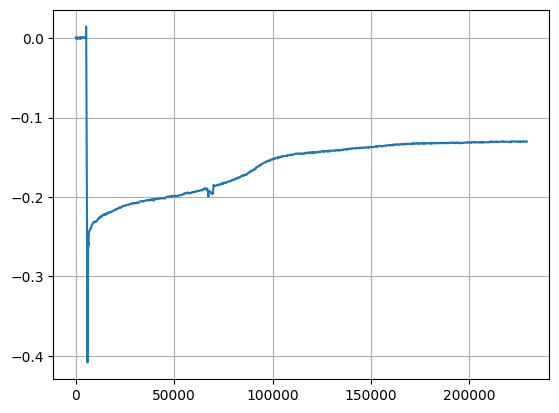

In [21]:
import matplotlib.pyplot as plt
test_data = pd.read_csv('./Programming/smoothed_signal_file_35.csv')
plt.plot(test_data['Smoothed Voltage'])
plt.grid()

In [22]:
with tf.device('/CPU:0'):
    
    rnn_variation = load_model(r"C:\Users\birud\OneDrive - iitgn.ac.in\github\CS-299-Project\Programming\models\variation_model.h5")
    svm_wounded = load_model(r"C:\Users\birud\OneDrive - iitgn.ac.in\github\CS-299-Project\Programming\models\wounded_model.h5")

    j = 0
    start = 0
    end = test_data['Smoothed Voltage'].tail(1).index.item()
    gap1 = 500
    gap2 = 500
    gap3 = 5000
    wound_time = 0
    cols = ['start_m', 'max_min', 'maxi', 'mini', 'final_initial', 'final', 'initial', 'variance', 'IQR']
    Xtest = pd.DataFrame(columns=['start_m', 'max_min', 'maxi', 'mini', 'final_initial', 'final', 'initial', 'variance', 'IQR'])
    num = (end - start) // gap1
    wound = 0
    y_pred_var_count = 0
    while (start != end) and (j != num):
        subset = abs(test_data['Smoothed Voltage'][start:start + gap2])
        start_m = 0
        max_min = subset.max() - subset.min()
        maxi = subset.max()
        mini = subset.min()
        final_initial = subset.iloc[gap2-1] - subset.iloc[0]
        final = subset.iloc[gap2-1]
        initial = subset.iloc[0]
        variance = subset.var()
        Q3 = np.quantile(subset, 0.75)
        Q1 = np.quantile(subset, 0.25)
        IQR = Q3 - Q1

        if wound:
            subset_var = abs(test_data['Smoothed Voltage'][start:start + gap3])
            start_m = start - m
            max_min = subset_var.max() - subset_var.min()
            maxi = subset_var.max()
            mini = subset_var.min()
            final_initial = subset_var.iloc[gap3-1] - subset_var.iloc[0]
            final = subset_var.iloc[gap3-1]
            initial = subset_var.iloc[0]
            variance = subset_var.var()
            Q3 = np.quantile(subset_var, 0.75)
            Q1 = np.quantile(subset_var, 0.25)
            IQR = Q3 - Q1

            Xtest.loc[j] = [start_m, max_min, maxi, mini, final_initial, final, initial, variance, IQR]
            Xtest_normal = scaler2.transform(Xtest.iloc[[j]])
            Xtest_normal = Xtest_normal.reshape((Xtest_normal.shape[0], 1, Xtest_normal.shape[1]))
            y_pred_var = rnn_variation.predict(Xtest_normal)

            if y_pred_var[0][0] > 0.5:
                y_pred_var_count += 1

            else:
                y_pred_var_count = 0

        Xtest.loc[j] = [start_m, max_min, maxi, mini, final_initial, final, initial, variance, IQR]
        xt = Xtest.iloc[[j]]
        xt_wound = xt[['max_min', 'final_initial', 'variance', 'IQR']].copy()
        xt_wound_normal = scaler1.transform(xt_wound)
        xt_wound_normal = xt_wound_normal.reshape((xt_wound_normal.shape[0], 1, xt_wound_normal.shape[1]))
        y_pred_wound = svm_wounded.predict(xt_wound_normal)

        if y_pred_wound[0][0] > 0.5:
            wound = 1
            wound_time = start
            wound_cycles_check = j
            m = wound_time

        if wound and (j - wound_cycles_check) > 20 and y_pred_var_count >= 5 :
            break

        start += gap1
        j += 1

    print(f"The plant experienced injury at {wound_time/6000:.3f} minutes.")

    # Clean up to run the next model
    Xtest = Xtest.iloc[0:0]
    Xtest = pd.DataFrame(columns=['start_m', 'max_min', 'maxi', 'mini', 'final_initial', 'final', 'initial', 'variance', 'IQR'])
    gap1 = 500
    gap2 = 5000
    start = wound_time
    m = wound_time
    j = 0
    num = (end - start) // gap1
    count_var = 0
    not_VP_check = 0
    while (start != end) and (j != num):
        
        if (start + gap2 > end):
            break
            
        subset = abs(test_data['Smoothed Voltage'][start:start + gap2])
        start_m = start - m
        max_min = subset.max() - subset.min()
        maxi = subset.max()
        mini = subset.min()
        final_initial = subset.iloc[4999] - subset.iloc[0]
        final = subset.iloc[4999]
        initial = subset.iloc[0]
        variance = subset.var()
        Q3 = np.quantile(subset, 0.75)
        Q1 = np.quantile(subset, 0.25)
        IQR = Q3 - Q1

        Xtest.loc[j] = [start_m, max_min, maxi, mini, final_initial, final, initial, variance, IQR]
        Xtest_var_normal = scaler2.transform(Xtest.iloc[[j]])
        Xtest_var_normal = Xtest_var_normal.reshape((Xtest_var_normal.shape[0], 1, Xtest_var_normal.shape[1]))
        y_pred_model2 = rnn_variation.predict(Xtest_var_normal)

        if y_pred_model2[0][0] > 0.5:
            not_VP_check = 0
            count_var += 1
            if count_var == 1:
                start_VP = start

        else:
            not_VP_check += 1

        if not_VP_check >= 5:
            end_VP = start
            break

        start += gap1
        j += 1

    print(f"The variation potential occurs from {(start_VP + 500)/6000:.3f} minutes to {end_VP/6000:.3f} minutes.")

    print(f"The healthy potential extends from {end_VP/6000:.3f} minutes to {end/6000:.3f} minutes.")

    print(f"The recording is stopped after {end/6000:.3f} minutes.")

The plant experienced injury at 0.917 minutes.
The variation potential occurs from 1.000 minutes to 28.833 minutes.
The healthy potential extends from 28.833 minutes to 38.202 minutes.
The recording is stopped after 38.202 minutes.


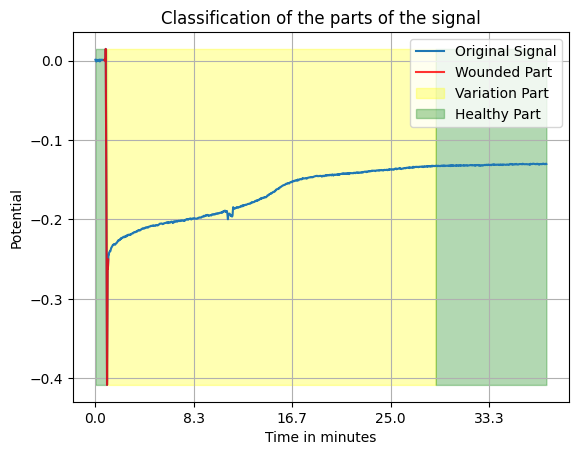

In [23]:
def format_ticks(value, pos):
    return f"{value/(100*60):.1f}"

formatter = FuncFormatter(format_ticks)

end_graph = end
plt.plot(test_data['Smoothed Voltage'][0:end_graph], label='Original Signal')
plt.plot(test_data['Smoothed Voltage'][wound_time - 1000 : start_VP + 1000], color='r', label='Wounded Part', alpha=0.8)  # Adjust alpha for transparency
plt.fill_between(range(start_VP + 500, end_VP), test_data['Smoothed Voltage'].min(), test_data['Smoothed Voltage'].max(), color='yellow', alpha=0.3, label='Variation Part')
plt.fill_between(range(end_VP, end_graph), test_data['Smoothed Voltage'].min(), test_data['Smoothed Voltage'].max(), color='green', alpha=0.3, label='Healthy Part')
plt.fill_between(range(0, wound_time), test_data['Smoothed Voltage'].min(), test_data['Smoothed Voltage'].max(), color='green', alpha=0.3)
plt.grid()
plt.legend()
plt.xlabel("Time in minutes")
plt.ylabel("Potential")
plt.title("Classification of the parts of the signal")
plt.gca().xaxis.set_major_formatter(formatter)

plt.show()